In [1]:
import pandas as pd
import geopandas as gd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import rasterio
import rasterio.warp
from rasterio import features
import shapely.geometry
import shapely
import seaborn as sn

In [2]:
os.chdir('/projects/canis/eoc_feature_corr')

In [3]:
grid_path = "./data/by_state/WV/wv_extent_coverage.shp"
grid = gd.read_file(grid_path)
grid = grid.set_index('id')

In [4]:
feature_path = './data/cover/NLCD_2016_Land_Cover_L48_20190424_3857.tiff'

feature_file = rasterio.open(feature_path)
feature_raster = feature_file.read(1)

In [5]:
feature_legend_path = './data/cover/NLCD_landcover_legend_2018_12_17_IGrpwzCAkFkyZtKBIu8z.csv'
feature_legend = pd.read_csv(feature_legend_path)
feature_legend = feature_legend.set_index('Value')
feature_legend = feature_legend.dropna()

In [6]:
feature_legend

,Legend
Value,
0,Unclassified
11,Open Water
12,Perennial Snow/Ice
21,"Developed, Open Space"
22,"Developed, Low Intensity"
23,"Developed, Medium Intensity"
24,"Developed, High Intensity"
31,Barren Land
41,Deciduous Forest


In [7]:
grid['centroid'] = grid['geometry'].centroid
grid = grid.set_geometry('centroid')
grid['feature'] = grid['centroid'].map(lambda coords: next(feature_file.sample(coords.coords, indexes=1))[0])
grid = grid.set_geometry('geometry')
grid = grid.drop('centroid', axis=1)
grid

,left,top,right,bottom,med_rxpwr,chg_covera,verizon_co,geometry,feature
id,,,,,,,,,
231.0,-9.152446e+06,4.595449e+06,-9.151446e+06,4.594449e+06,-120.000,0,0,"POLYGON ((-9152445.857 4595449.221, -9151445.8...",41
241.0,-9.152446e+06,4.585449e+06,-9.151446e+06,4.584449e+06,-120.000,0,0,"POLYGON ((-9152445.857 4585449.221, -9151445.8...",41
579.0,-9.151446e+06,4.596449e+06,-9.150446e+06,4.595449e+06,-120.000,0,1,"POLYGON ((-9151445.857 4596449.221, -9150445.8...",41
590.0,-9.151446e+06,4.585449e+06,-9.150446e+06,4.584449e+06,-120.000,0,0,"POLYGON ((-9151445.857 4585449.221, -9150445.8...",41
591.0,-9.151446e+06,4.584449e+06,-9.150446e+06,4.583449e+06,-120.000,0,0,"POLYGON ((-9151445.857 4584449.221, -9150445.8...",41
...,...,...,...,...,...,...,...,...,...
173860.0,-8.654446e+06,4.768449e+06,-8.653446e+06,4.767449e+06,-107.930,1,1,"POLYGON ((-8654445.857 4768449.221, -8653445.8...",21
173861.0,-8.654446e+06,4.767449e+06,-8.653446e+06,4.766449e+06,-108.075,1,1,"POLYGON ((-8654445.857 4767449.221, -8653445.8...",41
174209.0,-8.653446e+06,4.768449e+06,-8.652446e+06,4.767449e+06,-102.595,1,1,"POLYGON ((-8653445.857 4768449.221, -8652445.8...",23


In [8]:
grid = grid.join(feature_legend, how="left", on='feature')

In [9]:
grid['agreement'] = grid['chg_covera'] == grid['verizon_co']

In [10]:
sn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [11]:
confusion_matrix = pd.crosstab( grid['Legend'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], normalize='index')
print (confusion_matrix)

Agreement                         False     True 
Cover Type                                       
Barren Land                    0.909091  0.090909
Cultivated Crops               0.282895  0.717105
Deciduous Forest               0.496546  0.503454
Developed, High Intensity      0.187500  0.812500
Developed, Low Intensity       0.328638  0.671362
Developed, Medium Intensity    0.333333  0.666667
Developed, Open Space          0.419753  0.580247
Emergent Herbaceuous Wetlands  0.375000  0.625000
Evergreen Forest               0.520000  0.480000
Hay/Pasture                    0.473684  0.526316
Herbaceuous                    0.437500  0.562500
Mixed Forest                   0.443737  0.556263
Open Water                     0.340909  0.659091
Shrub/Scrub                    0.450000  0.550000
Woody Wetlands                 0.500000  0.500000


In [12]:
confusion_matrix['Total'] = grid.groupby('Legend').count()['agreement']

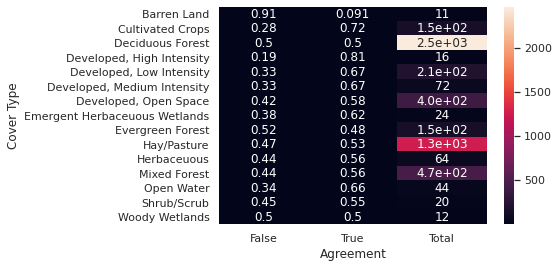

In [13]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

Agreement                      False  True   All
Cover Type                                      
Barren Land                       10     1    11
Cultivated Crops                  43   109   152
Deciduous Forest                1222  1239  2461
Developed, High Intensity          3    13    16
Developed, Low Intensity          70   143   213
Developed, Medium Intensity       24    48    72
Developed, Open Space            170   235   405
Emergent Herbaceuous Wetlands      9    15    24
Evergreen Forest                  78    72   150
Hay/Pasture                      594   660  1254
Herbaceuous                       28    36    64
Mixed Forest                     209   262   471
Open Water                        15    29    44
Shrub/Scrub                        9    11    20
Woody Wetlands                     6     6    12
All                             2490  2879  5369


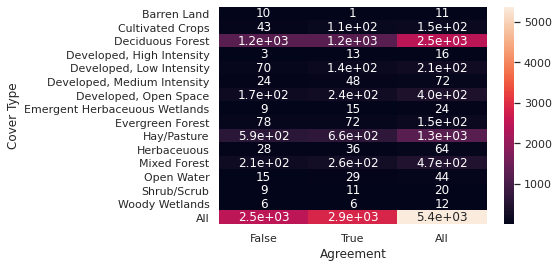

In [14]:
confusion_matrix = pd.crosstab( grid['Legend'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], margins=True)
print (confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)
plt.show()